In [20]:
import matplotlib as plt
import textwrap

In [3]:
import sys
sys.path.append('..')
from utils import *

In [103]:
arxiv_number_list=['1106.6060','1812.04213','2004.04168','2008.08998','2012.04554','2108.02159']

In [99]:
prompt_template='../prompt_template.md'
arxiv_number='1106.6060'
prompt_dict=load_prompt_template(prompt_template)
with open(os.path.join('..',f'{arxiv_number}',f'{arxiv_number}.yaml'),'r') as f:
    kwargs= yaml.safe_load(f)

In [100]:
kwargs[1]['score']

{'in_paper': 2,
 'prompt_quality': 2,
 'follow_instructions': 2,
 'physics_logic': 2,
 'math_derivation': 2,
 'final_answer_accuracy': 2}

In [101]:
tasks = [f'Task:{len(kwargs)-idx-2} '+kwarg['task'] for idx,kwarg in enumerate(kwargs[:0:-1])]
aspect_score={}
for kwarg in kwargs[:0:-1]:
    for key,value in reversed(list(kwarg['score'].items())):
        if key not in aspect_score:
            aspect_score[key]=[value]
        else:
            aspect_score[key].append(value)

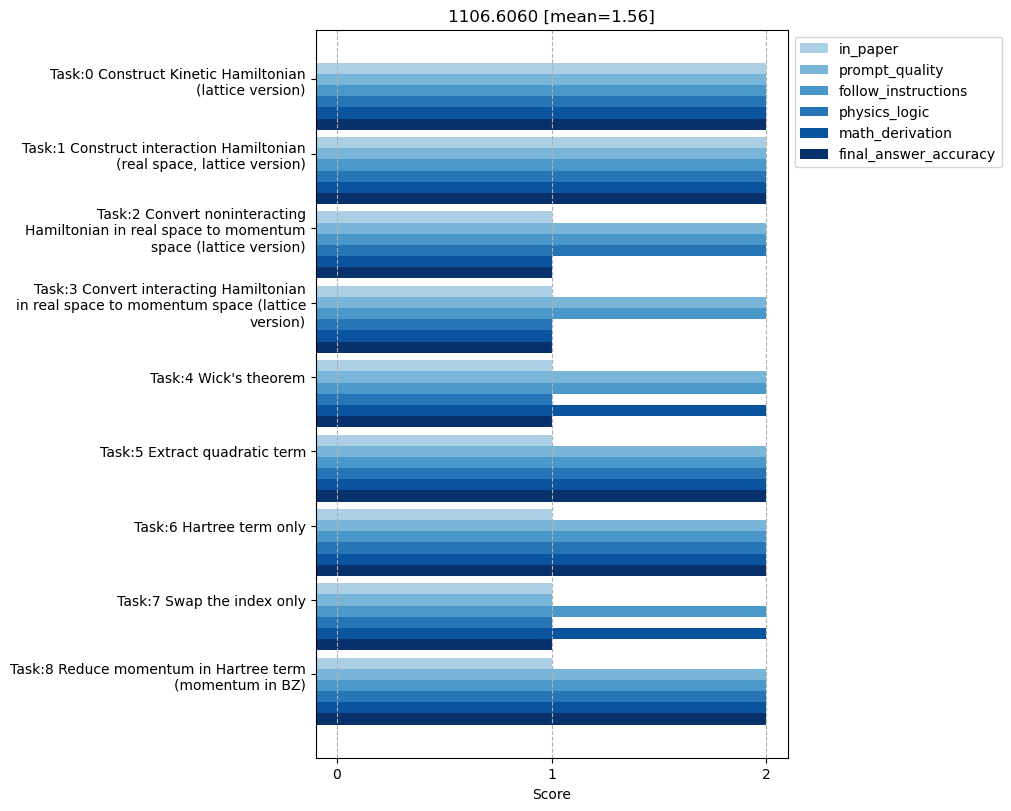

In [102]:
import matplotlib.pyplot as plt
import numpy as np

tasks = [f'Task:{len(kwargs)-idx-2} '+kwarg['task'] for idx,kwarg in enumerate(kwargs[:0:-1])]
aspect_score={}
for kwarg in kwargs[:0:-1]:
    for key,value in reversed(list(kwarg['score'].items())):
        if key not in aspect_score:
            aspect_score[key]=[value]
        else:
            aspect_score[key].append(value)


x = np.arange(len(tasks))  # the label locations
width = 0.15  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained',figsize=(10,8))
color_list=[plt.cm.Blues(0.2+0.8*(i/6)) for i in range(6,0,-1)]
for attribute, measurement in aspect_score.items():
    offset = width * multiplier
    rects = ax.barh(x + offset, np.array(measurement)+0.1, width, label=attribute,color=color_list[multiplier],left=-0.1)
    # ax.bar_label(rects, padding=3)
    multiplier += 1

ax.set_xlabel('Score')
ax.set_xticks([0,1,2])
ax.set_title(f"{arxiv_number} [mean={np.mean(aspect_score['final_answer_accuracy']):.2f}]")
ax.set_yticks(x + width*4, ['\n'.join(textwrap.wrap(task, width=40)) for task in tasks])

handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles[::-1], labels[::-1],loc='upper left', ncols=1,bbox_to_anchor=(1, 1))

ax.grid(axis='x',ls='--')
# ax.set_ylim(0, 250)
ax.set_xlim(-0.1,2.1)

plt.show()

In [93]:
aspect_score

{'final_answer_accuracy': [2, 2, 2, 0, 1, 2, 1, 1, 2, 2, 1],
 'math_derivation': [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
 'physics_logic': [2, 2, 2, 0, 1, 2, 1, 2, 2, 2, 2],
 'follow_instructions': [2, 2, 2, None, 0, 2, 2, 1, 2, 2, 2],
 'prompt_quality': [1, 1, 1, 2, 2, 2, 2, 1, 1, 1, 1],
 'in_paper': [1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1]}

In [ ]:
tasks = [f'Task:{len(kwargs)-idx-2} '+kwarg['task'] for idx,kwarg in enumerate(kwargs[:0:-1])]
aspect_score={}
for kwarg in kwargs[:0:-1]:
    for key,value in reversed(list(kwarg['score'].items())):
        if key not in aspect_score:
            aspect_score[key]=[value]
        else:
            aspect_score[key].append(value)

In [110]:
import pandas as pd

In [111]:
def load_score(arxiv_number):
    prompt_template='../prompt_template.md'
    # arxiv_number='1106.6060'
    prompt_dict=load_prompt_template(prompt_template)
    with open(os.path.join('..',f'{arxiv_number}',f'{arxiv_number}.yaml'),'r') as f:
        kwargs= yaml.safe_load(f)
    tasks=[f'Task:{idx} '+kwarg['task'] for idx,kwarg in enumerate(kwargs[1:])]
    aspect_score={}
    for kwarg in kwargs[1:]:
        for key,value in (list(kwarg['score'].items())):
            if key not in aspect_score:
                aspect_score[key]=[value]
            else:
                aspect_score[key].append(value)
    return pd.DataFrame(aspect_score,index=tasks)

In [118]:
df_list=[load_score(arxiv_number) for arxiv_number in arxiv_number_list]

In [119]:
dfs=pd.concat(df_list,keys=arxiv_number_list,names=['arxiv_number','task'])

Text(0.5, 0, 'Score')

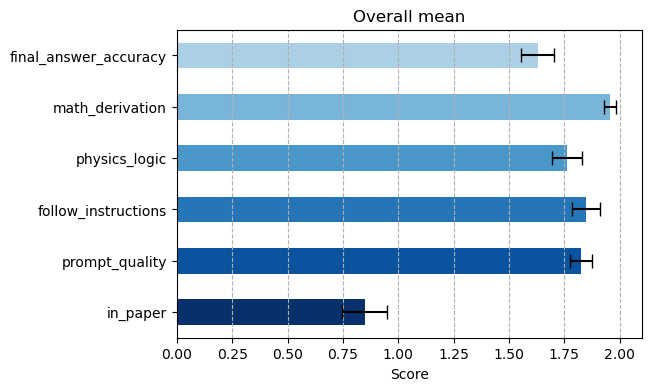

In [142]:
error_bar=dfs.std().values/dfs.shape[0]**0.5
dfs.mean().plot(kind='barh',figsize=(6,4),xlim=(0,2.1),title='Overall mean',color=color_list,xerr=error_bar,capsize=5)
plt.grid(axis='x',ls='--')
plt.xlabel('Score')

In [140]:
error_bar

array([0.10345522, 0.05031965, 0.06169627, 0.06884255, 0.02707336,
       0.07509226])

In [177]:
# group='in_paper'
group='prompt_quality'
mean=dfs.groupby(group)[['follow_instructions','physics_logic','math_derivation','final_answer_accuracy']].mean()
error_bar=dfs.groupby(group)[['follow_instructions','physics_logic','math_derivation','final_answer_accuracy']].std()/dfs.groupby(group)[['follow_instructions','physics_logic','math_derivation','final_answer_accuracy']].count()**0.5

In [178]:
mean

,follow_instructions,physics_logic,math_derivation,final_answer_accuracy
prompt_quality,,,,
1,1.875000,1.875000,2.000000,1.625000
2,1.842105,1.736842,1.947368,1.631579


In [179]:
list(mean.iterrows())

[(1,
  follow_instructions      1.875
  physics_logic            1.875
  math_derivation          2.000
  final_answer_accuracy    1.625
  Name: 1, dtype: float64),
 (2,
  follow_instructions      1.842105
  physics_logic            1.736842
  math_derivation          1.947368
  final_answer_accuracy    1.631579
  Name: 2, dtype: float64)]

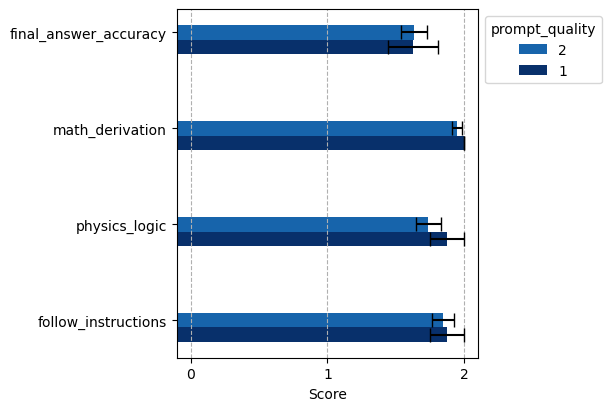

In [180]:
x = np.arange(mean.shape[1])  # the label locations
width = 0.15  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained',figsize=(6,4))
color_list=[plt.cm.Blues(0.2+0.8*(i/4)) for i in range(4,0,-1)]
# for attribute, measurement in aspect_score.items():
for attribute, measurement in mean.iterrows():
    offset = width * multiplier
    rects = ax.barh(x + offset, np.array(measurement)+0.1, width, label=attribute,color=color_list[multiplier],left=-0.1,xerr=error_bar.loc[attribute].values,capsize=5)
    # ax.bar_label(rects, padding=3)
    multiplier += 1

ax.set_xlabel('Score')
ax.set_xticks([0,1,2])
# ax.set_title(f"{arxiv_number}")
ax.set_yticks(x + width*1, ['\n'.join(textwrap.wrap(label, width=40)) for label in mean.columns])

handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles[::-1], labels[::-1],loc='upper left', ncols=1,bbox_to_anchor=(1, 1),title=group)

ax.grid(axis='x',ls='--')
# ax.set_ylim(0, 250)
ax.set_xlim(-0.1,2.1)

plt.show()